# In which I brazenly defy Professor Ng and do his anomaly detection homework in Python instead of Matlab.

Week 9 of Andrew Ng's ML course on Coursera discusses two very common applied ML algorithms: anomaly detection (think fraud detection or manufacturing quality control) and recommender systems (think Amazon or Netflix). Here I focus on the anomaly detection portion and use the homework data set to learn about the relevant python tools.

>## Tools Covered:
- `EllipticEnvelope` for fitting a multivariate Gaussian with a robust covariance estimate
- `IsolationForest` for a decision-tree approach to anomaly detection in higher dimensions
- `countourf` and `meshgrid` for plotting countours of a 3D function
- `StratifiedKFolds` for manually creating class-balanced cross-validation train/test splits
- `GridSearchCV` with `make_scorer` for using a different evaluation metric than your estimator's default

# Quick Look at the Data

In [3]:
import scipy.io
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle

#import snips as snp  # my snippets
#snp.prettyplot(matplotlib)  # my aesthetic preferences for plotting
%matplotlib inline

In [4]:
cd hw-wk9

C:\Users\SUKANYA SAHA\Desktop\Data Science\Data Science Projects\Projects\Anomaly-Detection\Andrew Ng 2\hw-wk9


### Anomaly Detection: Node Failure in a Network of Servers
In the anomaly detection part of this homework we are trying to predict when a particular server in a network is going to fail - hopefully an anomalous event! We have two data sets from this system to practice on: a toy set with only two features, and a higher dimensional data set that presents more of a challenge. In both sets each observation is a "response" from a server, which has certain characteristics like throughput in mb/sec and latency in milliseconds (the two features in the toy data set).

For both data sets we have labels for the points, meaning we know which server responses actually heralded a server failure and are considered "anomalous".

In [5]:
data = scipy.io.loadmat("ex8data1.mat")
trash, y1, X1 = data["X"], data["yval"], data["Xval"]
y1 = y1.reshape(len(y1))

In [6]:
data = scipy.io.loadmat("ex8data2.mat")
X2_normal, y2, X2 = data["X"], data["yval"], data["Xval"]
y2 = y2.reshape(len(y2))
y2_normal = np.array([0]*len(X2_normal))

In [7]:
y2 = np.concatenate([y2, y2_normal])
X2 = np.concatenate([X2, X2_normal]) 

In [8]:
X1.shape, X2.shape

((307, 2), (1100, 11))

TypeError: only integer scalar arrays can be converted to a scalar index

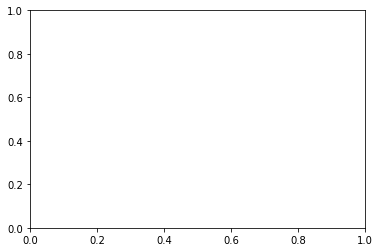

In [11]:
fig, ax = plt.subplots()
#snp.labs("throughput", "latency", "Toy Data: Server Responses")
ax.scatter(X1[y1==0:, 0], X1[y1==0:, 1], s=6, label="inliers")
ax.scatter(X1[y1==1, 0], X1[y1==1, 1], marker="x", color="r", label="outliers")
ax.legend(loc="lower right")

Since this cluster is pretty isotropic we shouldn't have much trouble with simple independent Gaussian modeling assumption common in density estimation for anomaly detection.

The second data set is a more difficult (read: realistic) set, it lives in a higher dimensinoal space *and* has fewer observations. We can't plot this data set natively, but we can do PCA to cast it to 2D. In theory the mode of the data in $R^n$ should still look like the mode of the data in $R^2$, right? (Right??).

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()

In [15]:
X = scaler.fit_transform(X2)
X_reduce = pca.fit_transform(X)

NameError: name 'snp' is not defined

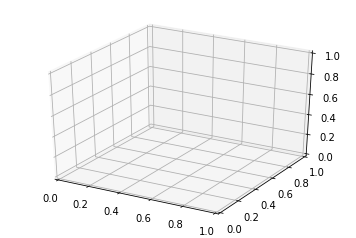

In [16]:
# Plot all the ground truth points together with the predictions
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
snp.labs("x_composite_1", "x_composite_2", "Outliers in Reduced Dimension")
ax.set_zlabel("x_composite_3")

# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=0, label="inliers")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[y2==1, 0], X_reduce[y2==1, 1], zs=X_reduce[y2==1, 2], 
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()

So even after some drastic compression (3-fold reduction) we can still see that outliers are more "marginal". 

# Anomaly Detection (AD)
**The heart of all AD is that you want to fit a generating distribution or decision boundary for normal points, and then use this to label new points as normal (AKA inlier) or anomalous (AKA outlier)** This comes in different flavors depending on the quality of your training data (see the [official sklearn docs](http://scikit-learn.org/stable/modules/outlier_detection.html) and also [this presentation](https://perso.telecom-paristech.fr/~goix/nicolas_goix_osi_presentation.pdf)):
- **Unsupservised (Outlier Detection)**. We have an unlabeled training set that we assume contains normal and outlier points, and we want to use robust tools which have a way of fitting a density to just the mode of the data and ignoring points far from this mode.
- **Semi-Supervised (Novelty Detection)**. We have a labeled training set containing only normal points that we fit a density for. Then we predict whether new points are anomalous or normal based on this density. 
- **Fully Supervised**. We have a labeled training set of known normal and known outlier points. We fit a density estimate using only normal points, and then fit a decision threshold on this density using a reserved sample of normal points and the known outliers. That is, you choose the probability threshold $\epsilon$ that gives you the best F1 score (or other evaluation metric suitable for skewed classes).

## Anomaly Detection in Sklearn
Scikit-learn has a host of AD-related tools:
- **`OneClassSVM`**: (supervised or semi-supervised) can fit a tight decision boundary around a set of normal points, but it will not do well with a mixed data set already containing outliers. 
- **`EllipticEnvelope`**: (unsupervised or supervised) it fits the tightest Gaussian (smallest volume ellipsoid) that it can while discarding some fixed fraction of *contamination* points set by the user. 
- **`IsolationForest`**: (unsupervised) this is a decision tree technique that works well in higher dimensional sets (since we've not covered decision trees I'll leave this alone).

A wonderful graphic from [the sklearn user guide](http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html#sphx-glr-auto-examples-covariance-plot-outlier-detection-py) shows a comparison of the performance of these tools on different data sets:

<img src=http://scikit-learn.org/stable/_images/sphx_glr_plot_outlier_detection_0011.png width=600></img>
<img src=http://scikit-learn.org/stable/_images/sphx_glr_plot_outlier_detection_0021.png width=600></img>
<img src=http://scikit-learn.org/stable/_images/sphx_glr_plot_outlier_detection_0031.png width=600></img>

## Unsupervised AD with EllipticEnvelope
First let's pretend we don't have labels, i.e. we don't know which server responses actually heralded a server failure and are considered "anomalous". Let's see how reasonable of a picture we can paint with an unsupervised approach.

A relatively simple model for the inlier-generating distribution is the multivariate Gaussian, which is parameterized by $\mu \in R^n$ and a covariance matrix $\Sigma \in R^{nxn}$. This model can capture *correlations* between the data, so it can distort the Gaussian along any $x_i = x_2$ line and take an ellipsoid shape generally. The class `EllipticEnvelope` takes your unlabeled $X$ and `fit`s such a multivariate Gaussian density to it. 

**The presence of outliers in $X$ can cause a huge distortion in the fitted Gaussian, but a more robust estimate can be had by modifying the parameter `contamination` which indicates the fraction of points in $X$ which the class is free to discard in fitting.** `EllipticEnvelope` will then determine which points to discard such that it can fit the ellipsoid with smallest volume. With an unlableled data set we'll have to guess a reasonable level for outlier contamination: something between 0 and 5 % should be realistic if your dealing with *actual* outliers.

In [17]:
from sklearn.covariance import EllipticEnvelope
outlier_frac = 0.035
ell = EllipticEnvelope(contamination=outlier_frac)
ell.fit(X1)

EllipticEnvelope(assume_centered=False, contamination=0.035,
         random_state=None, store_precision=True, support_fraction=None)

Per usual, this class implements a `predict` method which returns a binary "outlier" or "not outlier" decision. Alternatively the `decision_function` method returns a continuous value that reflects the fitted density at the input point(s). 

In [19]:
# Binary prediction of normal vs. outlier
pred = ell.predict(X1)
sum(pred == -1)  # Outlier points are predicted as -1

11

In [21]:
# Continuous output of the decision_function
decision = ell.decision_function(X1)
decision.min(), decision.max()


array([ 0.47794883,  1.37122828,  0.6978732 ,  0.9383988 ,  1.05031214,
        0.48905074,  0.83741885,  1.47311293,  0.33722111,  1.09217478,
        1.34936515,  0.54027873,  0.53554918,  0.25550575,  0.56503199,
        0.74435518,  0.5242502 ,  0.79236622,  1.17729087,  0.75839579,
        1.687245  ,  0.60659867,  1.35390556,  1.18363568,  1.10783585,
        1.41261501,  0.74710481,  0.89076121,  0.67044844,  1.04193161,
        1.26123008,  0.92942426,  1.05731128,  1.60729146,  0.97677383,
        1.14726006,  0.97733029,  0.43664114,  0.79790379,  1.66180388,
        0.87831152,  0.50266515,  0.73063824,  1.47641846,  1.58785719,
        0.95142809,  0.50936052,  1.56149114,  1.21639578,  0.95501002,
        0.8270244 ,  1.64865638,  1.2393184 ,  1.30955597,  0.72890599,
        0.87063078,  0.96382562,  0.81388805,  0.58495896,  0.92371079,
        1.57806301,  0.70156499,  1.43534458,  0.42210814,  1.07676485,
        0.36511468,  1.13827871,  1.56592823,  0.57655631,  1.32

In [24]:
# Get the "thresholding" value from the decision function
threshold = stats.scoreatpercentile(ell.decision_function(X1), 100*outlier_frac)
threshold

0.0005734459635047158

A good way to visualize the fitted Gaussian distributions are with a countour plot over a `meshgrid` representing our feature plane. 

In [25]:
# First make a meshgrid for the (x1, x2) feature space
x1s = np.linspace(np.min(X1[:, 0])-5, np.max(X1[:, 0])+5, 15)
x2s = np.linspace(np.min(X1[:, 1])-5, np.max(X1[:, 1])+5, 15)
x1grid, x2grid = np.meshgrid(x1s, x2s) 

In [26]:
x1grid, x2grid

(array([[-4.69206154, -1.96107244,  0.76991666,  3.50090575,  6.23189485,
          8.96288395, 11.69387304, 14.42486214, 17.15585124, 19.88684034,
         22.61782943, 25.34881853, 28.07980763, 30.81079673, 33.54178582],
        [-4.69206154, -1.96107244,  0.76991666,  3.50090575,  6.23189485,
          8.96288395, 11.69387304, 14.42486214, 17.15585124, 19.88684034,
         22.61782943, 25.34881853, 28.07980763, 30.81079673, 33.54178582],
        [-4.69206154, -1.96107244,  0.76991666,  3.50090575,  6.23189485,
          8.96288395, 11.69387304, 14.42486214, 17.15585124, 19.88684034,
         22.61782943, 25.34881853, 28.07980763, 30.81079673, 33.54178582],
        [-4.69206154, -1.96107244,  0.76991666,  3.50090575,  6.23189485,
          8.96288395, 11.69387304, 14.42486214, 17.15585124, 19.88684034,
         22.61782943, 25.34881853, 28.07980763, 30.81079673, 33.54178582],
        [-4.69206154, -1.96107244,  0.76991666,  3.50090575,  6.23189485,
          8.96288395, 11.69387304,

In [27]:
# Now make predictions for each point on the grid 
Xgrid = np.column_stack((x1grid.ravel(), x2grid.ravel()))  # Feature matrix containing all grid points
dens = ell.decision_function(Xgrid)
densgrid = dens.reshape(x1grid.shape)  # Reshape the vector of densities back onto the "grid"

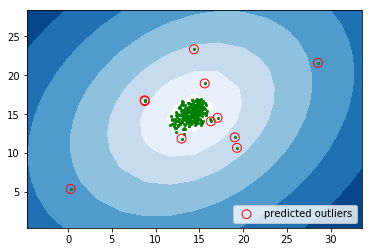

In [28]:
# Use the densites as the "z" values in a contour plot on the grid
fig, ax = plt.subplots()
#snp.labs("throughput", "latency", "Outlier Decision Function Contours")
ax.contourf(x1grid, x2grid, densgrid, cmap=plt.cm.Blues_r, levels=np.linspace(dens.min(), threshold, 7))
ax.scatter(X1[:, 0], X1[:, 1], s=4, color="g")

# Pot circles around the predicted outliers
ax.scatter(X1[pred == -1, 0], X1[pred == -1, 1],  
           facecolors="none", edgecolors="red", s=80, label="predicted outliers")
ax.legend(loc="lower right")

### Overly Robust Covariance Estimation
Using a contamination value of 3.5% looks reasonable, but not great. What happens if we just don't tell the class how much contamination there is? To my eye it gets a little overexcited in discarding points... Probably better in most cases to set a reasonable contamination value.

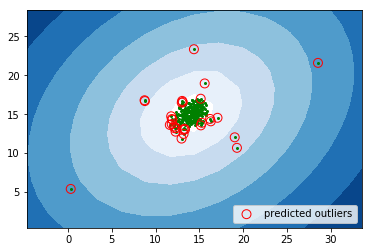

In [31]:
# Let it discard as many points as it wants in fitting
ell = EllipticEnvelope()
ell.fit(X1)
pred = ell.predict(X1)

# Use the densites as the "z" values in a contour plot on the grid
fig, ax = plt.subplots()
#snp.labs("throughput", "latency", "Maximally Robust Fit")
ax.contourf(x1grid, x2grid, densgrid, cmap=plt.cm.Blues_r, levels=np.linspace(dens.min(), threshold, 7))
ax.scatter(X1[:, 0], X1[:, 1], s=4, color="g")

# Pot circles around the predicted outliers
ax.scatter(X1[pred == -1, 0], X1[pred == -1, 1],  
           facecolors="none", edgecolors="red", s=80, label="predicted outliers")
ax.legend(loc="lower right")

## Supervised AD with EllipticEnvelope and GridSearchCV
Obviously we don't want to just *guess* a good contamination value - and in higher dimensional sets we'd be hard-pressed to get any kind of visual feedback on our guesses. Since we have labels for our data we can run use `EllipticEnvelope` in a supervised way with a grid search through the `contamination` parameter. This turns out to be not quite so straightforward as with some estimators...

**First we need to recast our y-values into the form that `EllipticEnvelope` uses: 1 and -1 rather than 0 and 1.** We'll also reshape it to the right sklearn shape (a true vector rather than an array of arrays).

In [32]:
y1 = y1.astype(np.int8)
y1[y1==1] = -1
y1[y1==0] = 1

Sadly with very skewed classes we can't do simple K-Fold cross-validation because we probably won't get a good sampling of the underrepresented class in each fold. We instead want `StratifiedKFold`, which  pays attention to lables to ensure a representative balance in each fold. This would* be what `GridSearchCV` uses by default if our estimator was a classifier, but `EllipticEnvelope` is not. So instead we need to specify the grid search `cv` as an iterable which contains manual train/test splits... boo :(

In [33]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
folds = list(skf.split(X1, y1))

Finally, the default scoring for `EllipticEnvelope` is mean classification accuracy, which is absolutely terrible for skewed class applications (it does very well by just ignoring the underrepresented class entirely). We'll want to instead use the `recall_score` metric which reflects how well the algorithm can correctly identify positive examples (outliers). This metric can be transformed into a sklearn scoring function using the `make_scorer` function.

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

f1sc = make_scorer(f1_score)
ps = {"contamination": np.linspace(0.0, 0.05, 15)}
search = GridSearchCV(estimator=ell, param_grid=ps, scoring=f1sc, cv=folds)
search.fit(X1, y1)

GridSearchCV(cv=[(array([102, 103, ..., 305, 306]), array([  0,   1, ..., 101, 300])), (array([  0,   1, ..., 305, 306]), array([102, 103, ..., 302, 303])), (array([  0,   1, ..., 302, 303]), array([201, 202, ..., 305, 306]))],
       error_score='raise',
       estimator=EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'contamination': array([0.     , 0.00357, 0.00714, 0.01071, 0.01429, 0.01786, 0.02143,
       0.025  , 0.02857, 0.03214, 0.03571, 0.03929, 0.04286, 0.04643,
       0.05   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=0)

In [35]:
df = pd.DataFrame(search.cv_results_)
df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head()

C:\anaconada\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconada\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconada\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconada\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are acc

,mean_test_score,std_test_score,params
5,0.996678,0.004675,{'contamination': 0.01785714285714286}
4,0.995009,0.004045,{'contamination': 0.014285714285714287}
6,0.993288,0.004736,{'contamination': 0.02142857142857143}
3,0.990050,0.003985,{'contamination': 0.010714285714285714}
0,0.988413,0.004629,{'contamination': 0.0}


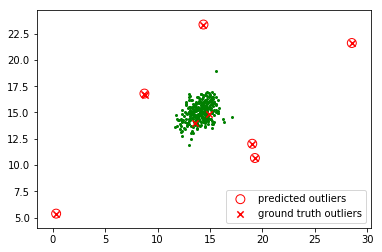

In [36]:
# Make predictions with our optimized envelope fit
optimal_ell = search.best_estimator_
pred = optimal_ell.predict(X1)

# Use the densites as the "z" values in a contour plot on the grid
fig, ax = plt.subplots()
#snp.labs("throughput", "latency", "Outlier Decision Function Contours")
# ax.contourf(x1grid, x2grid, densgrid, cmap=plt.cm.Blues_r, levels=np.linspace(dens.min(), threshold, 7))
ax.scatter(X1[:, 0], X1[:, 1], s=4, color="g")

# Plot circles around the predicted outliers
ax.scatter(X1[pred == -1, 0], X1[pred == -1, 1],  
           facecolors="none", edgecolors="red", s=80, label="predicted outliers")

# Plot x's for the ground truth outliers
ax.scatter(X1[y1 == -1, 0], X1[y1 == -1, 1], marker="x", 
           color="r", s=40, label="ground truth outliers")

ax.legend(loc="lower right")

## Higher Dimensional Anomaly Detection
Now let's try this on the high-dimensional data set. This is going to be much more difficult because now we have 11 features and only 100 observations! First get $y2$ ship shape:

In [38]:
y2 = y2.astype(np.int8)
y2[y2==1] = -1
y2[y2==0] = 1

### Don't Use EllipticEnvelope Unless You Have Lots of Data
To fit the full multivariate Gaussian we need at least $n^2/2$ points, where $n$ is the number of features. We really don't have enough data to do a good job with this model, so let me just show you how bad it actually is... 

In [39]:
# Grid Search over contamination fraction
skf = StratifiedKFold(n_splits=3)
folds = list(skf.split(X2, y2))
ell = EllipticEnvelope()
f1sc = make_scorer(f1_score)
ps = {"contamination": np.linspace(0.0, 0.05, 15)}
search = GridSearchCV(estimator=ell, param_grid=ps, scoring=f1sc, cv=folds)
search.fit(X2, y2)

GridSearchCV(cv=[(array([  38,   59, ..., 1098, 1099]), array([  0,   1, ..., 372, 373])), (array([   0,    1, ..., 1098, 1099]), array([ 38,  59, ..., 735, 736])), (array([  0,   1, ..., 735, 736]), array([  88,   91, ..., 1098, 1099]))],
       error_score='raise',
       estimator=EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'contamination': array([0.     , 0.00357, 0.00714, 0.01071, 0.01429, 0.01786, 0.02143,
       0.025  , 0.02857, 0.03214, 0.03571, 0.03929, 0.04286, 0.04643,
       0.05   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=0)

Remember, we're in $R^{11}$ so we'll need our PCA-compressed representations to visualize these results.

In [40]:
# Make predictions with our optimized envelope fit
optimal_ell = search.best_estimator_
pred = optimal_ell.predict(X2)

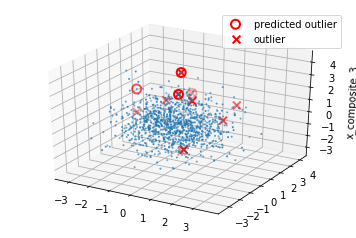

In [41]:
# Plot all the reduced-dimensionality ground truth points together with the predictions
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#snp.labs("x_composite_1", "x_composite_2", "Outliers in Reduced Dimension")
ax.set_zlabel("x_composite_3")

# Plot the reduced dimensionality data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=0)

# Plot circles around the predicted outliers
ax.scatter(X_reduce[pred==-1, 0], X_reduce[pred==-1, 1], zs=X_reduce[pred==-1, 2], 
           lw=2, facecolors="none", edgecolors="r", s=80, label="predicted outlier")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[y2==-1, 0], X_reduce[y2==-1, 1], zs=X_reduce[y2==-1, 2], 
           lw=2, s=60, marker="x", c="red", label="outlier")
ax.legend()

## Try IsolationForests for High Dimensions

In [909]:
from sklearn.ensemble import IsolationForest
forest = IsolationForest()

# Grid Search over contamination fraction
skf = StratifiedKFold(n_splits=3) 
folds = list(skf.split(X2, y2))
forest = IsolationForest()
forest.contamination = sum(y2==-1)/len(y2)
f1sc = make_scorer(f1_score)
ps = {"n_estimators": (55, 75, 95, 115)}
search = GridSearchCV(estimator=forest, param_grid=ps, scoring=f1sc, cv=folds)
search.fit(X2, y2)

GridSearchCV(cv=[(array([  38,   59, ..., 1098, 1099]), array([  0,   1, ..., 372, 373])), (array([   0,    1, ..., 1098, 1099]), array([ 38,  59, ..., 735, 736])), (array([  0,   1, ..., 735, 736]), array([  88,   91, ..., 1098, 1099]))],
       error_score='raise',
       estimator=IsolationForest(bootstrap=False, contamination=0.0090909090909090905,
        max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
        random_state=None, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (55, 75, 95, 115)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score), verbose=0)

In [910]:
df = pd.DataFrame(search.cv_results_)
df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head()

,mean_test_score,std_test_score,params
3,0.994958,0.001296,{'n_estimators': 115}
1,0.994034,0.000657,{'n_estimators': 75}
2,0.992650,0.001311,{'n_estimators': 95}
0,0.991720,0.000011,{'n_estimators': 55}


In [907]:
# Make predictions with our optimized decision tree
optimal_forest = search.best_estimator_
pred = optimal_forest.predict(X2)

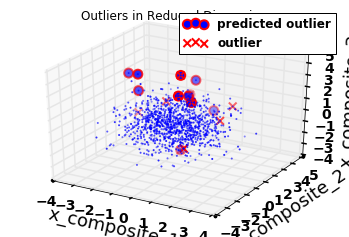

In [911]:
# Plot all the reduced-dimensionality ground truth points together with the predictions
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
snp.labs("x_composite_1", "x_composite_2", "Outliers in Reduced Dimension")
ax.set_zlabel("x_composite_3")

# Plot the reduced dimensionality data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=0)

# Plot circles around the predicted outliers
ax.scatter(X_reduce[pred==-1, 0], X_reduce[pred==-1, 1], zs=X_reduce[pred==-1, 2], 
           lw=2, facecolors="none", edgecolors="r", s=80, label="predicted outlier")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[y2==-1, 0], X_reduce[y2==-1, 1], zs=X_reduce[y2==-1, 2], 
           lw=2, s=60, marker="x", c="red", label="outlier")
ax.legend()